<center><h1>Backpropagation From Scratch</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

In this notebook, we'll code a **Logistic Regression** and a two-layers **Multi-Layer Perceptron** (MLP) from scratch.

We'll use **pytorch** a deep learning framework. It provides many utilities for neural networks (layers, optimizers, automatic differentiation), but we'll only use its API to manipulate tensors as we would with numpy.

The goal will be to learn a model with **backpropagation** in order to classify digits (0, 1, 2, ..., 9) from images.

---

# 1. Loading Data

In [ ]:
%matplotlib inline

In [ ]:
import torch
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

In [ ]:
X = torch.tensor(digits["images"]).float()
Y = torch.tensor(digits["target"]).long()

print(f"Images shape: {X.shape}, targets shape: {Y.shape}")

Images shape: torch.Size([1797, 8, 8]), targets shape: torch.Size([1797])


We have 1797 images, each of size 8x8. As you see, there is no **channel dimension** meaning that our images are in grayscale. Which is ok for now, as we only want to classify digits.

The targets shape is 1797 because, for each image a target is simply an integer representing the digit.

Now that our data is loaded, we need to visualize it. Always look at your data before doing anything! Something may be wrong with the data (not in this case).

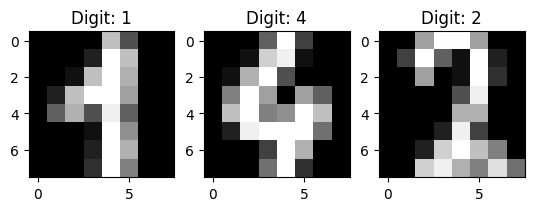

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(X[42], cmap="gray")
plt.title(f"Digit: {Y[42]}");

plt.subplot(1, 3, 2)
plt.imshow(X[64], cmap="gray")
plt.title(f"Digit: {Y[64]}");

plt.subplot(1, 3, 3)
plt.imshow(X[1337], cmap="gray")
plt.title(f"Digit: {Y[1337]}");

For this dataset, the pixels are coded with 4 bits, meaning that we can have values from 0 to 16 ($2^4$). In deep learning, it's very important to normalize the data in order to have all inputs of relatively the same magnitude.

**Beware**: this preprocessing must be done for both the train and test sets! A lot of bugs come from using a slightly different preprocessing between the two sets.

In [ ]:
print(f"Min and max value of images pixels [{X.min()}, {X.max()}]")
X = X / 16
print(f"Min and max value of normalized images pixels [{X.min()}, {X.max()}]")

Min and max value of images pixels [0.0, 16.0]
Min and max value of normalized images pixels [0.0, 1.0]


MLP only accepts inputs that are vectors, thus we will flatten our images into vectors:

In [ ]:
# Flatten images as vectors
print(f"Images shape: {X.shape}")
X = X.view(X.shape[0], -1)
print(f"Flatten images shape: {X.shape}")

Images shape: torch.Size([1797, 8, 8])
Flatten images shape: torch.Size([1797, 64])


---

# 2. Activation Functions

Now that the data is loaded and preprocessed, we need to code the non-linear activation functions that are essential to deep learning.

First let's start by `softmax`, the final activation, that will give us a probability per digit. It takes as input a vector of **logits** (the final outputs of the network before softmax, one value per digit) and returns a vector of probabilities.

Here is the formula for the $i^\text{th}$ probability:

$$\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [ ]:
def softmax(x):
  exp_x = torch.exp(x)
  return exp_x / exp_x.sum()
print(softmax(torch.tensor([1., 2., 3.])))
print(softmax(torch.tensor([3., -0.12, -4.2, 9])))

tensor([0.0900, 0.2447, 0.6652])
tensor([2.4723e-03, 1.0917e-04, 1.8458e-06, 9.9742e-01])


In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_base.py
%pycat softmax_base.py

--2023-12-13 21:48:37--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_base.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 54.161.234.33, 35.169.59.174, 2600:1f18:16e:df01::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|54.161.234.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/x-python3]
Saving to: ‘softmax_base.py.1’

softmax_base.py.1   100%[===================>]     155  --.-KB/s    in 0s      

2023-12-13 21:48:37 (44.6 MB/s) - ‘softmax_base.py.1’ saved [155/155]



Because the output vector is a probability distribution, all individual probabilities should sum to 1, let's check that:

In [ ]:
print(softmax(torch.tensor([1., 2., 3.])).sum())
print(softmax(torch.tensor([3., -0.12, -4.2, 9])).sum())

tensor(1.)
tensor(1.)


What if our model is very very confident about class 0:

In [ ]:
softmax(torch.tensor([234., 3., 4.]))

tensor([nan, 0., 0.])

Why did we have a NaN? How can we fix it?

In [ ]:
def softmax(x):
  max = x.max()
  exp_x = torch.exp(x - max)
  return exp_x / exp_x.sum()

softmax(torch.tensor([234., 3., 4.]))

tensor([1., 0., 0.])

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_nan.py
%pycat softmax_nan.py

--2023-12-13 21:49:18--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_nan.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 44.217.161.11, 54.84.236.175, 2600:1f18:2489:8200::c8, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|44.217.161.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143 [text/x-python3]
Saving to: ‘softmax_nan.py’

softmax_nan.py      100%[===================>]     143  --.-KB/s    in 0s      

2023-12-13 21:49:19 (65.4 MB/s) - ‘softmax_nan.py’ saved [143/143]



Perfectly identical:

$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i - c}}{\sum_j e^{x_j - c}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{-c} e^{x_i}}{e^{-c} \sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \operatorname{softmax}(\mathbf{x})_i$$


In practice, we will have mini-batch, i.e. our probabilities tensor will be of shape $(B, C)$:

In [ ]:
x = torch.tensor([
    [1., 2., 3.],
    [4., 9., -12.]
])
probabilities = softmax(x)

print(probabilities.sum())
print(probabilities.sum(dim=1))

tensor(1.0000)
tensor([0.0037, 0.9963])


The whole batch probabilities sum to 1! That's not what we want. What did go wrong? Remember that most pytorch function can be applied only alongside a dimension.

In [ ]:
def softmax(x):
  max = x.max(dim=1, keepdims=True).values
  exp_x = torch.exp(x - max)
  return exp_x / exp_x.sum(dim=1, keepdims=True)

x = torch.tensor([
    [1., 2., 3.],
    [4., 9., -12.]
])
probabilities = softmax(x)

print(probabilities.sum(dim=1))
preds = probabilities.argmax(dim=1)
preds

tensor([1., 1.])


tensor([2, 1])

In [ ]:
labels = torch.tensor([2, 3])

t = labels - preds
print(t)
len(t[t == 0]) / len(labels) * 100

tensor([0, 2])


50.0

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_batch.py
%pycat softmax_batch.py

--2023-12-13 21:53:38--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_batch.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 44.217.161.11, 18.213.222.111, 2600:1f18:2489:8202::c8, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|44.217.161.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267 [text/x-python3]
Saving to: ‘softmax_batch.py’

softmax_batch.py    100%[===================>]     267  --.-KB/s    in 0s      

2023-12-13 21:53:38 (78.2 MB/s) - ‘softmax_batch.py’ saved [267/267]



Now, what about a loss? Let's code the cross-entropy!

Tips:
- Remember about the dimensions, we have mini-batches
- Log of 0 is undefined, what trick can we do then?

In [ ]:
def cross_entropy(probs, targets):
  log_probs = torch.log(probs + 1e-8)
  prod = targets * log_probs
  return - torch.sum(prod, dim=1)

probs = torch.tensor([
    [0.9, 0.1],
    [0.7, 0.3],
    [0.2, 0.8],
    [0.6, 0.4]
])

targets = torch.eye(2)[torch.tensor([0, 0, 0, 1])]
cross_entropy(probs, targets)

tensor([0.1054, 0.3567, 1.6094, 0.9163])

In [ ]:
torch.mean((probs == targets).float())

tensor(0.)

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/ce.py
%pycat ce.py

--2023-12-13 21:54:18--  https://deepcourse-epita.netlify.app/code/backpropagation/ce.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.213.222.111, 54.161.234.33, 2600:1f18:16e:df01::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.213.222.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271 [text/x-python3]
Saving to: ‘ce.py’

ce.py               100%[===================>]     271  --.-KB/s    in 0s      

2023-12-13 21:54:18 (218 MB/s) - ‘ce.py’ saved [271/271]



Loss is most important when we are wrong by a large margin. Likewise it is smallest when we are extremely confident. Now you should see that the cross-entropy is maximizing the confidence (also known as the *likelihood*) into the ground-truth class.

Try running the cross-entropy with different probabilities to get an intuition about it.

---

# 3. Logistic Regression

Now that we have our `softmax` activation and `cross-entropy` loss, we can code a **logistic regression**. Behind this fancy name, it's simply a 1-layer neural network followed a softmax.

Here is the forward formula:

$$\tilde{\mathbf{y}} = \mathbf{X}\mathbf{W} + \mathbf{b}$$
$$\hat{\mathbf{y}} = \text{softmax}(\tilde{\mathbf{y}})$$
$$\mathcal{L} = -\frac{1}{B} \sum_{b=1}^B y_b \log \hat{\mathbf{y}}_b $$

With $\mathbf{X} \in \mathbb{R}^{B \times N}$, $\mathbf{W} \in \mathbb{R}^{N \times C}$, and $\mathbf{b} \in \mathbb{R}^{C}$. With $B$ being the batch size, $N$ the number of input pixels, and $C$ the number of classes.

For the backward, We can simplify formulas with a shortcut by taking directly the gradient of the loss $\mathcal{L}$ with relation to (w.r.t) the logits $\tilde{\mathbf{y}}$ (*see course for details*):

$$\nabla_\tilde{\mathbf{y}} \mathcal{L} = \hat{\mathbf{y}} - \mathbf{y}$$

Only two gradients are of interest: the one with relation to (w.r.t) the weights $\mathbf{W}$ and $\mathbf{b}$, the neurons we want to update.

$$\nabla_\mathbf{W} \mathcal{L} = (\nabla_\mathbf{W} \tilde{\mathbf{y}})^T \nabla_\tilde{\mathbf{y}} \mathcal{L}$$
$$\nabla_\mathbf{b} \mathcal{L} = \nabla_\tilde{\mathbf{y}} \mathcal{L}$$

**Hint**: Look at the shape of each tensor if you're confused, i.e., the gradient $\nabla_\mathbf{W} \mathcal{L}$ should have the same shape as $\mathbf{W}$!


We also recall that the gradient with respect to W are a matrix based on $X$ and not simply $X$
$$ \frac{\partial WX + b}{\partial W_{k,l}} = \frac{\sum_{j=1}^{J} W_{k,j} X_{j} + b_k}{\partial W_{k,l}} = X_l
$$


In [ ]:
class LogisticRegression:
    def __init__(self, input_size, nb_classes, learning_rate=0.5):
        self.w = torch.empty(input_size, nb_classes)
        torch.nn.init.xavier_normal_(self.w)
        self.b = torch.zeros(nb_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        return torch.mm(x, self.w) + self.b

    def fit(self, inputs, targets, train=True):
        probs = softmax(self.forward(inputs))
        if train:
          self.backward(inputs, probs, targets)
        return cross_entropy(probs, torch.eye(10)[targets]).mean()
         # torch.eye used to allow pointwise mul (targets is R^B and we need R^{BxC})
         # mean used to get a scalar that holds any sense but won't be used anyway

    def backward(self, inputs, probs, targets):
        batch_size = len(inputs)
        loss_grad = probs - torch.eye(10)[targets]
        grad_b = torch.sum(loss_grad, dim=0) / batch_size
        grad_w = torch.mm(inputs.T, loss_grad) / batch_size

        self.w = self.w - self.learning_rate * grad_w
        self.b = self.b - self.learning_rate * grad_b
        # TODO, should be called by `fit`

    def accuracy(self, inputs, targets):
        preds = self.forward(inputs).argmax(dim=1)
        return torch.mean((preds == targets).float())
         # mean used to get a scalar that holds any sense but won't be used anyway

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/logreg.py
%pycat logreg.py

--2023-10-25 01:58:12--  https://deepcourse-epita.netlify.app/code/backpropagation/logreg.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 50.18.215.94, 13.57.148.141, 2600:1f1c:446:4900::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|50.18.215.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [text/x-python3]
Saving to: ‘logreg.py.2’

logreg.py.2         100%[===================>]   1.06K  --.-KB/s    in 0s      

2023-10-25 01:58:13 (23.7 MB/s) - ‘logreg.py.2’ saved [1086/1086]



In [ ]:
model = LogisticRegression(X.shape[1], len(torch.unique(Y)), 0.5)

Let's measure the accuracy of the untrained model. What does it, roughtly, correspond to? Any idea why?

In [ ]:
model.accuracy(X, Y)

tensor(0.1002)

Let's train! We are going to see the whole dataset `nb_epochs` times, by chunk of `batch_size` images.

**Note** that we are training and testing on the same set here for simplicity, but in later courses, or in real-life, don't do that.

Epoch: 0, loss: 0.7523345947265625, accuracy: 0.7929883003234863
Epoch: 1, loss: 0.41806986927986145, accuracy: 0.9087367653846741
Epoch: 2, loss: 0.3133191764354706, accuracy: 0.9354479908943176
Epoch: 3, loss: 0.26345184445381165, accuracy: 0.9454646706581116
Epoch: 4, loss: 0.23374299705028534, accuracy: 0.9493600726127625
Epoch: 5, loss: 0.21345780789852142, accuracy: 0.9510294795036316
Epoch: 6, loss: 0.19836169481277466, accuracy: 0.9571508169174194
Epoch: 7, loss: 0.186475932598114, accuracy: 0.9616026878356934
Epoch: 8, loss: 0.17674918472766876, accuracy: 0.9627156257629395
Epoch: 9, loss: 0.16856467723846436, accuracy: 0.9632720947265625


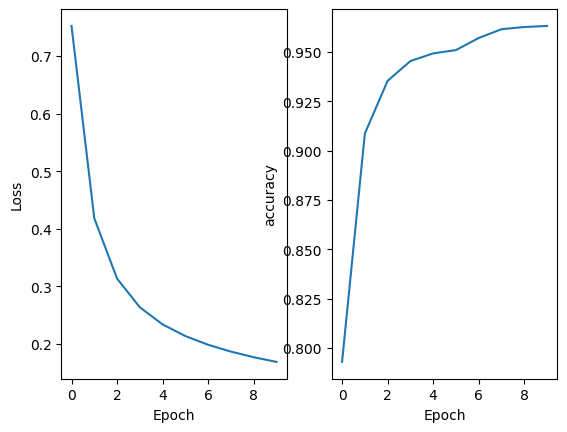

In [ ]:
batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        loss = model.fit(batch_X, batch_Y)

    loss = model.fit(X, Y, train=False)
    acc = model.accuracy(X, Y)

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

---

# 4. Multi-Layer Perceptron

Now, let's build a Multi-Layer Perceptron, aka a neural network with hidden layers.

Hidden layers imply hidden activations. `tanh` is already implemented for you: `torch.tanh`.

This function is applied **element-wise**, meaning that it is applied independently on every point of the tensor (not like softmax). We now need the gradient of this function:

In [ ]:
def grad_tanh(tanh_results):
    return 1 - tanh_results ** 2

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/gradtanh.py
%pycat gradtanh.py

--2023-10-25 01:09:10--  https://deepcourse-epita.netlify.app/code/backpropagation/gradtanh.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 50.18.215.94, 13.57.148.141, 2600:1f1c:446:4901::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|50.18.215.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62 [text/x-python3]
Saving to: ‘gradtanh.py’

gradtanh.py         100%[===================>]      62  --.-KB/s    in 0s      

2023-10-25 01:09:10 (37.2 MB/s) - ‘gradtanh.py’ saved [62/62]



Now the MLP is like the Logistic Regression we coded previously, but with hidden layers!

We'll only start with one hidden layer to start. The forward should be straightforward, and for the backward try to derive it by yourself. If you're really stuck, you can have a look at the code solution, or the course. But after you've tried enough!

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, nb_classes, learning_rate=0.1):
        self.w_hidden = torch.empty((input_size, hidden_size))
        torch.nn.init.xavier_normal_(self.w_hidden)
        self.b_hidden = torch.zeros(hidden_size)

        self.w_output = torch.empty((hidden_size, nb_classes))
        torch.nn.init.xavier_normal_(self.w_output)
        self.b_output = torch.zeros(nb_classes)

        self.learning_rate = learning_rate

    def forward(self, x):
        h_tilde = torch.mm(x, self.w_hidden) + self.b_hidden
        h = torch.tanh(h_tilde)
        logits = torch.mm(h, self.w_output) + self.b_output
        probs = softmax(logits)
        return h_tilde, h, logits, probs
       # Remember to keep all intermediary values that are needed for the backward pass

    def fit(self, inputs, targets, train=True):
        h_tilde, h, logits, probs = self.forward(inputs)
        if train:
          self.backward(inputs, targets, h_tilde, h, logits, probs)
        return cross_entropy(probs, torch.eye(10)[targets]).mean()

    def backward(self, inputs, targets, h_tilde, h, logits, probs):
      batch_size = len(inputs)
      loss_grad = probs - torch.eye(10)[targets]
      grad_w_output = torch.mm(h.T, loss_grad) / batch_size
      grad_b_output = torch.sum(loss_grad, dim=0) / batch_size

      loss_grad_h = torch.mm(loss_grad, self.w_output.T) * grad_tanh(h) # huh ?
      grad_w_hidden = torch.mm(inputs.T, loss_grad_h) / batch_size
      grad_b_hidden = torch.sum(loss_grad_h, dim=0) / batch_size

      self.w_output = self.w_output - self.learning_rate * grad_w_output
      self.b_output = self.b_output - self.learning_rate * grad_b_output

      self.w_hidden = self.w_hidden - self.learning_rate * grad_w_hidden
      self.b_hidden = self.b_hidden - self.learning_rate * grad_b_hidden

    def accuracy(self, inputs, targets):
        preds = self.forward(inputs)[-2].argmax(dim=1)
        return torch.mean((preds == targets).float())

The same code used for the Logisitic Regression can also be used for the MLP.

That's the beauty of it, as long as our model can take in inputs images and predicts their digits, we don't care about the internals in the training loops:

Epoch: 0, loss: 0.36261895298957825, accuracy: 0.900389552116394
Epoch: 1, loss: 0.21063801646232605, accuracy: 0.9410127997398376
Epoch: 2, loss: 0.16497142612934113, accuracy: 0.9532554149627686
Epoch: 3, loss: 0.14220218360424042, accuracy: 0.9582637548446655
Epoch: 4, loss: 0.12774595618247986, accuracy: 0.9638286232948303
Epoch: 5, loss: 0.11688178032636642, accuracy: 0.9660545587539673
Epoch: 6, loss: 0.10776999592781067, accuracy: 0.9693934321403503
Epoch: 7, loss: 0.09971089661121368, accuracy: 0.9716193675994873
Epoch: 8, loss: 0.0924701914191246, accuracy: 0.9738453030586243
Epoch: 9, loss: 0.0859774649143219, accuracy: 0.9755147695541382


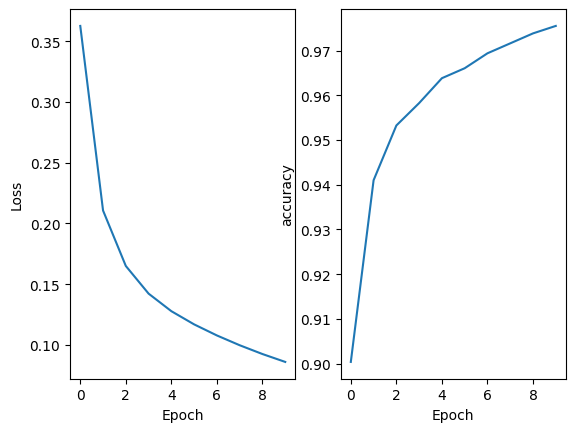

In [ ]:
model = MLP(X.shape[1], 50, len(torch.unique(Y)), 0.5)
model.accuracy(X, Y)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        model.fit(batch_X, batch_Y)

    loss = model.fit(X, Y, train=False)
    acc = model.accuracy(X, Y)

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/mlp.py
%pycat mlp.py

--2023-10-31 09:31:21--  https://deepcourse-epita.netlify.app/code/backpropagation/mlp.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 35.169.59.174, 44.217.161.11, 2600:1f18:16e:df00::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|35.169.59.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1871 (1.8K) [text/x-python3]
Saving to: ‘mlp.py’

mlp.py              100%[===================>]   1.83K  --.-KB/s    in 0s      

2023-10-31 09:31:21 (35.6 MB/s) - ‘mlp.py’ saved [1871/1871]



---

# Notebook Summary

We learn how to:
- code a robust softmax
- logistic regression with forward and backward pass
- MLP with forward and backward pass

# Further Works

- Try to implement a MLP with two hidden layers, or three, or as much as the user want, through a simple API.
- Does the initialization of the weights matter? Try tweaking it (more on it in later courses)